Before running the code, please download the required package first like torch, numpy ...

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import init
import math
import torch.nn as nn
import torch.nn.functional as F
import os

d:\Anaconda\envs\GPU_Pytorchpy39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


The code below will automatically create a path './data' and download MNIST dataset

In [2]:
transform = transforms.Compose(
    [torchvision.transforms.ToTensor()])

batch_size = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

Define the hardware tuning property <--- Hardware-aware training

In [3]:
def lorentzian_curve(x, A, x0, gamma):
    return -2 * A / (1 + ((x - x0) / gamma)**2) +A
def lorentzian_curve_derivative(x, A, x0, gamma):
    return 2 * A * (x - x0) / (gamma**2 * (1 + ((x - x0) / gamma)**2)**2)
def lorentzian_inv(y, A, x0, gamma):
    return gamma * ((A + y)/(A - y)) ** (1/2) + x0

Self defines the convolution layer and linear layer <--- Now we are optimizing the tuning currents/voltages, which differs directly optimizing the weights ! This is a very important step !

In [4]:
from torch.nn.modules.conv import _ConvNd
from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
from torch.nn.modules.utils import _pair
from typing import Optional, List, Tuple, Union

In [5]:
class Conv2dLorentz(_ConvNd):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        device=None,
        dtype=None
    ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super().__init__(
            in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
            False, _pair(0), groups, bias, padding_mode, **factory_kwargs)

    def _conv_forward(self, input: torch.Tensor, weight: torch.Tensor, bias: Optional[torch.Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self._conv_forward(input, lorentzian_curve(self.weight, 1, 0, 0.15), self.bias)

In [6]:
class LinearLorentz(torch.nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(lorentzian_curve(self.weight, 1, 0, 0.15), a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(lorentzian_curve(self.weight, 1, 0, 0.15))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, lorentzian_curve(self.weight, 1, 0, 0.15), self.bias)

    def extra_repr(self) -> str:
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'


In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.fc2_in = None
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm1d(120)
        self.norm4 = nn.BatchNorm1d(84)

    def forward(self,x):

        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))

        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.norm3(x)
        x = F.relu(x)
        self.fc2_in = x.detach()
        x = self.fc2(x)
        x = self.norm4(x)
        x = F.relu(x)
        self.fc3_in = x.detach()        
        x = self.fc3(x)

        return x

    def apply_constraints(self):
        self.conv1.cuda().weight.data = torch.clamp(self.conv1.cuda().weight.data, -1, 1)
        self.conv2.cuda().weight.data = torch.clamp(self.conv2.cuda().weight.data, -1, 1)
        self.fc1.cuda().weight.data = torch.clamp(self.fc1.cuda().weight.data, -1, 1)
        self.fc2.cuda().weight.data = torch.clamp(self.fc2.cuda().weight.data, -1, 1)
        self.fc3.cuda().weight.data = torch.clamp(self.fc3.cuda().weight.data, -1, 1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net = LeNet5()
net.to(device)

cuda:0


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [8]:
class LeNet5_Lorentz(nn.Module):
    def __init__(self):
        super(LeNet5_Lorentz, self).__init__()
        self.conv1 = Conv2dLorentz(1, 6, 5, padding=2)
        self.conv2 = Conv2dLorentz(6, 16, 5)
        self.fc1 = LinearLorentz(16*5*5, 120)
        self.fc2 = LinearLorentz(120, 84)
        self.fc3 = LinearLorentz(84, 10)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm1d(120)
        self.norm4 = nn.BatchNorm1d(84)

    def forward(self,x):

        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))

        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.norm4(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

    def apply_constraints(self):
        self.conv1.cuda().weight.data = torch.clamp(self.conv1.cuda().weight.data, min=0)
        self.conv2.cuda().weight.data = torch.clamp(self.conv2.cuda().weight.data, min=0)
        self.fc1.cuda().weight.data = torch.clamp(self.fc1.cuda().weight.data, min=0)
        self.fc2.cuda().weight.data = torch.clamp(self.fc2.cuda().weight.data, min=0)
        self.fc3.cuda().weight.data = torch.clamp(self.fc3.cuda().weight.data, min=0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.to(device)

cuda:0


LeNet5_Lorentz(
  (conv1): Conv2dLorentz(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2dLorentz(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): LinearLorentz(in_features=400, out_features=120, bias=True)
  (fc2): LinearLorentz(in_features=120, out_features=84, bias=True)
  (fc3): LinearLorentz(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

##### Evaluate robustness

In [9]:
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

Add resonance drift to evalute the robustness

In [10]:
temp_drift_error = np.linspace(0,-2.0,21,endpoint=True)
sweep_error = temp_drift_error * 80 / 1000
total_accu_01 = []
for rotate in range(1):
    accu_01 = []
    for i in range(len(sweep_error)):
        PATH = '.\Training results/01-Standard BP.pth'
        net = LeNet5()
        net.load_state_dict(torch.load(PATH))
        PATH = ""
        net.to(device)
        net.apply_constraints()
        correct = 0
        total = 0
        n = 15 
        with torch.no_grad():
                dataiter = iter(testloader)
                for _ in range(n - 1):
                    next(dataiter)
                n_batch = next(dataiter)
                inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'W/O NOISE Accuracy 10000 test images: {100 * correct / total} %')
        shift_error = sweep_error[i]

        fc2 = net.fc2.cpu().weight.detach().numpy()
        fc3 = net.fc3.cpu().weight.detach().numpy()
        fc2_noise = lorentzian_curve(lorentzian_inv(fc2,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc2.shape[0],fc2.shape[1])),A=1, x0=0, gamma=0.15)
        fc3_noise = lorentzian_curve(lorentzian_inv(fc3,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc3.shape[0],fc3.shape[1])),A=1, x0=0, gamma=0.15)        
        net.fc2.cpu().weight.data = torch.tensor(fc2_noise).float().to(device)
        net.fc3.cpu().weight.data = torch.tensor(fc3_noise).float().to(device)
        
        net.to(device)
        correct = 0
        total = 0
        n = 15 
        with torch.no_grad():
                dataiter = iter(testloader)
                for _ in range(n - 1):
                    next(dataiter)  
                n_batch = next(dataiter)
                inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'W/ NOISE Accuracy 10000 test images: {100 * correct / total} %')
        print(f'--------------------------------------------------------------')
        accu_withnoise = correct / total
        accu_01.append(accu_withnoise)
    total_accu_01.append(accu_01)

W/O NOISE Accuracy 10000 test images: 100.0 %
W/ NOISE Accuracy 10000 test images: 100.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 100.0 %
W/ NOISE Accuracy 10000 test images: 91.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 100.0 %
W/ NOISE Accuracy 10000 test images: 82.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 100.0 %
W/ NOISE Accuracy 10000 test images: 74.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 100.0 %
W/ NOISE Accuracy 10000 test images: 68.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 100.0 %
W/ NOISE Accuracy 10000 test images: 66.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 100.0 %
W/ NOISE Accuracy 10000 test images

In [11]:
temp_drift_error = np.linspace(0,-2.0,21,endpoint=True)
sweep_error = temp_drift_error * 80 / 1000
total_accu_02 = []
for rotate in range(1):
    accu_02 = []
    for i in range(len(sweep_error)):
        PATH = '.\Training results/02-Standard NJ.pth'
        net = LeNet5()
        net.load_state_dict(torch.load(PATH))
        PATH = ""
        net.to(device)
        net.apply_constraints()
        correct = 0
        total = 0
        n = 15 
        with torch.no_grad():
                dataiter = iter(testloader)
                for _ in range(n - 1):
                    next(dataiter) 
                n_batch = next(dataiter)
                inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'W/O NOISE Accuracy 10000 test images: {100 * correct / total} %')
        shift_error = sweep_error[i]

        fc2 = net.fc2.cpu().weight.detach().numpy()
        fc3 = net.fc3.cpu().weight.detach().numpy()
        fc2_noise = lorentzian_curve(lorentzian_inv(fc2,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc2.shape[0],fc2.shape[1])),A=1, x0=0, gamma=0.15)
        fc3_noise = lorentzian_curve(lorentzian_inv(fc3,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc3.shape[0],fc3.shape[1])),A=1, x0=0, gamma=0.15)        
        net.fc2.cpu().weight.data = torch.tensor(fc2_noise).float().to(device)
        net.fc3.cpu().weight.data = torch.tensor(fc3_noise).float().to(device)
        
        net.to(device)
        correct = 0
        total = 0
        n = 15 
        with torch.no_grad():
                dataiter = iter(testloader)
                for _ in range(n - 1):
                    next(dataiter) 
                n_batch = next(dataiter)
                inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'W/ NOISE Accuracy 10000 test images: {100 * correct / total} %')
        print(f'--------------------------------------------------------------')
        accu_withnoise = correct / total
        accu_02.append(accu_withnoise)
    total_accu_02.append(accu_02)

W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 98.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 98.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 97.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 88.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 88.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 87.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 88.0 %

In [12]:
temp_drift_error = np.linspace(0,-2.0,21,endpoint=True)
sweep_error = temp_drift_error * 80 / 1000
total_accu_03 = []
for rotate in range(1):
    accu_03 = []
    for i in range(len(sweep_error)):
        PATH = '.\Training results/03-Pruning.pth'
        net = LeNet5()
        net.load_state_dict(torch.load(PATH))
        PATH = ""
        net.to(device)
        net.apply_constraints()
        correct = 0
        total = 0
        n = 15 
        with torch.no_grad():
                dataiter = iter(testloader)
                for _ in range(n - 1):
                    next(dataiter)  
                n_batch = next(dataiter)
                inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'W/O NOISE Accuracy 10000 test images: {100 * correct / total} %')
        shift_error = sweep_error[i]

        fc2 = net.fc2.cpu().weight.detach().numpy()
        fc3 = net.fc3.cpu().weight.detach().numpy()
        fc2_noise = lorentzian_curve(lorentzian_inv(fc2,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc2.shape[0],fc2.shape[1])),A=1, x0=0, gamma=0.15)
        fc3_noise = lorentzian_curve(lorentzian_inv(fc3,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc3.shape[0],fc3.shape[1])),A=1, x0=0, gamma=0.15)        
        net.fc2.cpu().weight.data = torch.tensor(fc2_noise).float().to(device)
        net.fc3.cpu().weight.data = torch.tensor(fc3_noise).float().to(device)
        
        net.to(device)
        correct = 0
        total = 0
        n = 15 
        with torch.no_grad():
                dataiter = iter(testloader)
                for _ in range(n - 1):
                    next(dataiter)  
                n_batch = next(dataiter)
                inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'W/ NOISE Accuracy 10000 test images: {100 * correct / total} %')
        print(f'--------------------------------------------------------------')
        accu_withnoise = correct / total
        accu_03.append(accu_withnoise)
    total_accu_03.append(accu_03)

W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 98.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 97.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 96.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 95.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 95.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 95.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 95.0 %

In [13]:
temp_drift_error = np.linspace(0,-2.0,21,endpoint=True)
sweep_error = temp_drift_error * 80 / 1000
total_accu_04 = []
for rotate in range(1):
    accu_04 = []
    for i in range(len(sweep_error)):
        PATH = '.\Training results/04-SAT.pth'
        net = LeNet5()
        net.load_state_dict(torch.load(PATH))
        PATH = ""
        net.to(device)
        net.apply_constraints()
        correct = 0
        total = 0
        n = 15 
        with torch.no_grad():
                dataiter = iter(testloader)
                for _ in range(n - 1):
                    next(dataiter) 
                n_batch = next(dataiter)
                inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'W/O NOISE Accuracy 10000 test images: {100 * correct / total} %')
        shift_error = sweep_error[i]

        fc2 = net.fc2.cpu().weight.detach().numpy()
        fc3 = net.fc3.cpu().weight.detach().numpy()
        fc2_noise = lorentzian_curve(lorentzian_inv(fc2,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc2.shape[0],fc2.shape[1])),A=1, x0=0, gamma=0.15)
        fc3_noise = lorentzian_curve(lorentzian_inv(fc3,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc3.shape[0],fc3.shape[1])),A=1, x0=0, gamma=0.15)        
        net.fc2.cpu().weight.data = torch.tensor(fc2_noise).float().to(device)
        net.fc3.cpu().weight.data = torch.tensor(fc3_noise).float().to(device)
        
        net.to(device)
        correct = 0
        total = 0
        n = 15 
        with torch.no_grad():
                dataiter = iter(testloader)
                for _ in range(n - 1):
                    next(dataiter)  
                n_batch = next(dataiter)
                inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'W/ NOISE Accuracy 10000 test images: {100 * correct / total} %')
        print(f'--------------------------------------------------------------')
        accu_withnoise = correct / total
        accu_04.append(accu_withnoise)
    total_accu_04.append(accu_04)

W/O NOISE Accuracy 10000 test images: 99.0 %
W/ NOISE Accuracy 10000 test images: 99.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 99.0 %
W/ NOISE Accuracy 10000 test images: 99.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 99.0 %
W/ NOISE Accuracy 10000 test images: 99.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 99.0 %
W/ NOISE Accuracy 10000 test images: 99.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 99.0 %
W/ NOISE Accuracy 10000 test images: 99.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 99.0 %
W/ NOISE Accuracy 10000 test images: 99.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 99.0 %
W/ NOISE Accuracy 10000 test images: 99.0 %

In [14]:
temp_drift_error = np.linspace(0,-2.0,21,endpoint=True)
sweep_error = temp_drift_error * 80 / 1000
total_accu_05 = []
for rotate in range(1):
    accu_05 = []
    for i in range(len(sweep_error)):
        PATH = '.\Training results/05-PAT.pth'
        net = LeNet5()
        net.load_state_dict(torch.load(PATH))
        PATH = ""
        net.to(device)
        net.apply_constraints()
        correct = 0
        total = 0
        n = 15 
        with torch.no_grad():
                dataiter = iter(testloader)
                for _ in range(n - 1):
                    next(dataiter)  
                n_batch = next(dataiter)
                inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'W/O NOISE Accuracy 10000 test images: {100 * correct / total} %')
        shift_error = sweep_error[i]

        fc2 = net.fc2.cpu().weight.detach().numpy()
        fc3 = net.fc3.cpu().weight.detach().numpy()
        fc2_noise = lorentzian_curve(lorentzian_inv(fc2,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc2.shape[0],fc2.shape[1])),A=1, x0=0, gamma=0.15)
        fc3_noise = lorentzian_curve(lorentzian_inv(fc3,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc3.shape[0],fc3.shape[1])),A=1, x0=0, gamma=0.15)        
        net.fc2.cpu().weight.data = torch.tensor(fc2_noise).float().to(device)
        net.fc3.cpu().weight.data = torch.tensor(fc3_noise).float().to(device)
        
        net.to(device)
        correct = 0
        total = 0
        n = 15 
        with torch.no_grad():
                dataiter = iter(testloader)
                for _ in range(n - 1):
                    next(dataiter) 
                n_batch = next(dataiter)
                inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'W/ NOISE Accuracy 10000 test images: {100 * correct / total} %')
        print(f'--------------------------------------------------------------')
        accu_withnoise = correct / total
        accu_05.append(accu_withnoise)
    total_accu_05.append(accu_05)

W/O NOISE Accuracy 10000 test images: 77.0 %
W/ NOISE Accuracy 10000 test images: 77.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 77.0 %
W/ NOISE Accuracy 10000 test images: 85.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 77.0 %
W/ NOISE Accuracy 10000 test images: 91.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 77.0 %
W/ NOISE Accuracy 10000 test images: 96.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 77.0 %
W/ NOISE Accuracy 10000 test images: 98.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 77.0 %
W/ NOISE Accuracy 10000 test images: 99.0 %
--------------------------------------------------------------
W/O NOISE Accuracy 10000 test images: 77.0 %
W/ NOISE Accuracy 10000 test images: 91.0 %

In [15]:
total_accu_01 = np.array(total_accu_01)
accu_mean_01 = np.nanmean(total_accu_01,axis=0) 
accu_01_low = np.nanpercentile(total_accu_01, 2.5, axis=0)
accu_01_up = np.nanpercentile(total_accu_01, 97.5, axis=0)

total_accu_02 = np.array(total_accu_02)
accu_mean_02 = np.nanmean(total_accu_02,axis=0) 
accu_02_low = np.nanpercentile(total_accu_02, 2.5, axis=0)
accu_02_up = np.nanpercentile(total_accu_02, 97.5, axis=0)

total_accu_03 = np.array(total_accu_03)
accu_mean_03 = np.nanmean(total_accu_03,axis=0) 
accu_03_low = np.nanpercentile(total_accu_03, 2.5, axis=0)
accu_03_up = np.nanpercentile(total_accu_03, 97.5, axis=0)

total_accu_04 = np.array(total_accu_04)
accu_mean_04 = np.nanmean(total_accu_04,axis=0) 
accu_04_low = np.nanpercentile(total_accu_04, 2.5, axis=0)
accu_04_up = np.nanpercentile(total_accu_04, 97.5, axis=0)

total_accu_05 = np.array(total_accu_05)
accu_mean_05 = np.nanmean(total_accu_05,axis=0) 
accu_05_low = np.nanpercentile(total_accu_05, 2.5, axis=0)
accu_05_up = np.nanpercentile(total_accu_05, 97.5, axis=0)

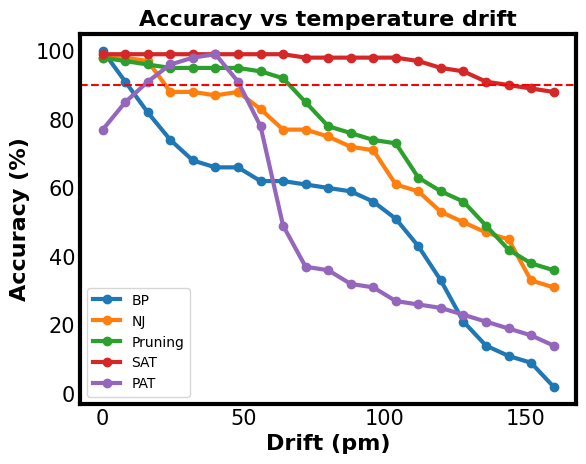

In [16]:
fig, ax = plt.subplots()

plt.plot(-sweep_error*1000, np.array(accu_mean_01)*100, 'o-',linewidth=3, color='C0')
plt.plot(-sweep_error*1000, np.array(accu_mean_02)*100, 'o-',linewidth=3, color='C1')
plt.plot(-sweep_error*1000, np.array(accu_mean_03)*100, 'o-',linewidth=3, color='C2')
plt.plot(-sweep_error*1000, np.array(accu_mean_04)*100, 'o-',linewidth=3, color='C3')
plt.plot(-sweep_error*1000, np.array(accu_mean_05)*100, 'o-',linewidth=3, color='C4')
plt.xlabel('Drift (pm)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Accuracy (%)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.title('Accuracy vs temperature drift', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.axhline(y=90, color='r', linestyle='--')
plt.rcParams["figure.figsize"] = (6, 4)
plt.legend(['BP','NJ','Pruning','SAT','PAT'], ncol=1)
for spine in ax.spines.values():
    spine.set_linewidth(3)

ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='both', labelsize=15)
plt.show()

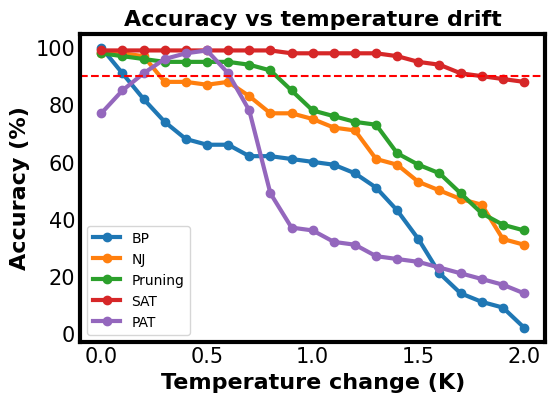

In [17]:
fig, ax = plt.subplots()

plt.plot(-sweep_error*1000/80, np.array(accu_mean_01)*100, 'o-',linewidth=3, color='C0')
plt.plot(-sweep_error*1000/80, np.array(accu_mean_02)*100, 'o-',linewidth=3, color='C1')
plt.plot(-sweep_error*1000/80, np.array(accu_mean_03)*100, 'o-',linewidth=3, color='C2')
plt.plot(-sweep_error*1000/80, np.array(accu_mean_04)*100, 'o-',linewidth=3, color='C3')
plt.plot(-sweep_error*1000/80, np.array(accu_mean_05)*100, 'o-',linewidth=3, color='C4')
plt.xlabel('Temperature change (K)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Accuracy (%)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.title('Accuracy vs temperature drift', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.axhline(y=90, color='r', linestyle='--')
plt.rcParams["figure.figsize"] = (6, 4)
# plt.legend(['Enhanced Baseline','SAM'], ncol=1)
plt.legend(['BP','NJ','Pruning','SAT','PAT'], ncol=1)
for spine in ax.spines.values():
    spine.set_linewidth(3)

ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='both', labelsize=15)
plt.show()

Plot confusion matrix

In [20]:
# PATH = '.\Training results/01-Standard BP.pth'
PATH = '.\Training results/02-Standard NJ.pth'
# PATH = '.\Training results/03-Pruning.pth'
# PATH = '.\Training results/04-SAT.pth'
# PATH = '.\Training results/05-PAT.pth'
net = LeNet5()
net.load_state_dict(torch.load(PATH))
PATH = ""
net.to(device)
net.apply_constraints()
correct = 0
total = 0
n = 15
with torch.no_grad():
        dataiter = iter(testloader)
        for _ in range(n - 1):
            next(dataiter) 
        n_batch = next(dataiter)
        inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'W/O NOISE Accuracy 10000 test images: {100 * correct / total} %')
temp_drift_error = -1.3
shift_error = temp_drift_error * 80 / 1000

fc2 = net.fc2.cpu().weight.detach().numpy()
fc3 = net.fc3.cpu().weight.detach().numpy()
fc2_noise = lorentzian_curve(lorentzian_inv(fc2,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc2.shape[0],fc2.shape[1])),A=1, x0=0, gamma=0.15)
fc3_noise = lorentzian_curve(lorentzian_inv(fc3,A=1, x0=0, gamma=0.15) + shift_error * np.ones((fc3.shape[0],fc3.shape[1])),A=1, x0=0, gamma=0.15)        
net.fc2.cpu().weight.data = torch.tensor(fc2_noise).float().to(device)
net.fc3.cpu().weight.data = torch.tensor(fc3_noise).float().to(device)

net.to(device)
correct = 0
total = 0
n = 15 
with torch.no_grad():
        dataiter = iter(testloader)
        for _ in range(n - 1):
            next(dataiter) 
        n_batch = next(dataiter)
        inputs, labels = n_batch[0].to(device), n_batch[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'W/ NOISE Accuracy 10000 test images: {100 * correct / total} %')

W/O NOISE Accuracy 10000 test images: 98.0 %
W/ NOISE Accuracy 10000 test images: 61.0 %


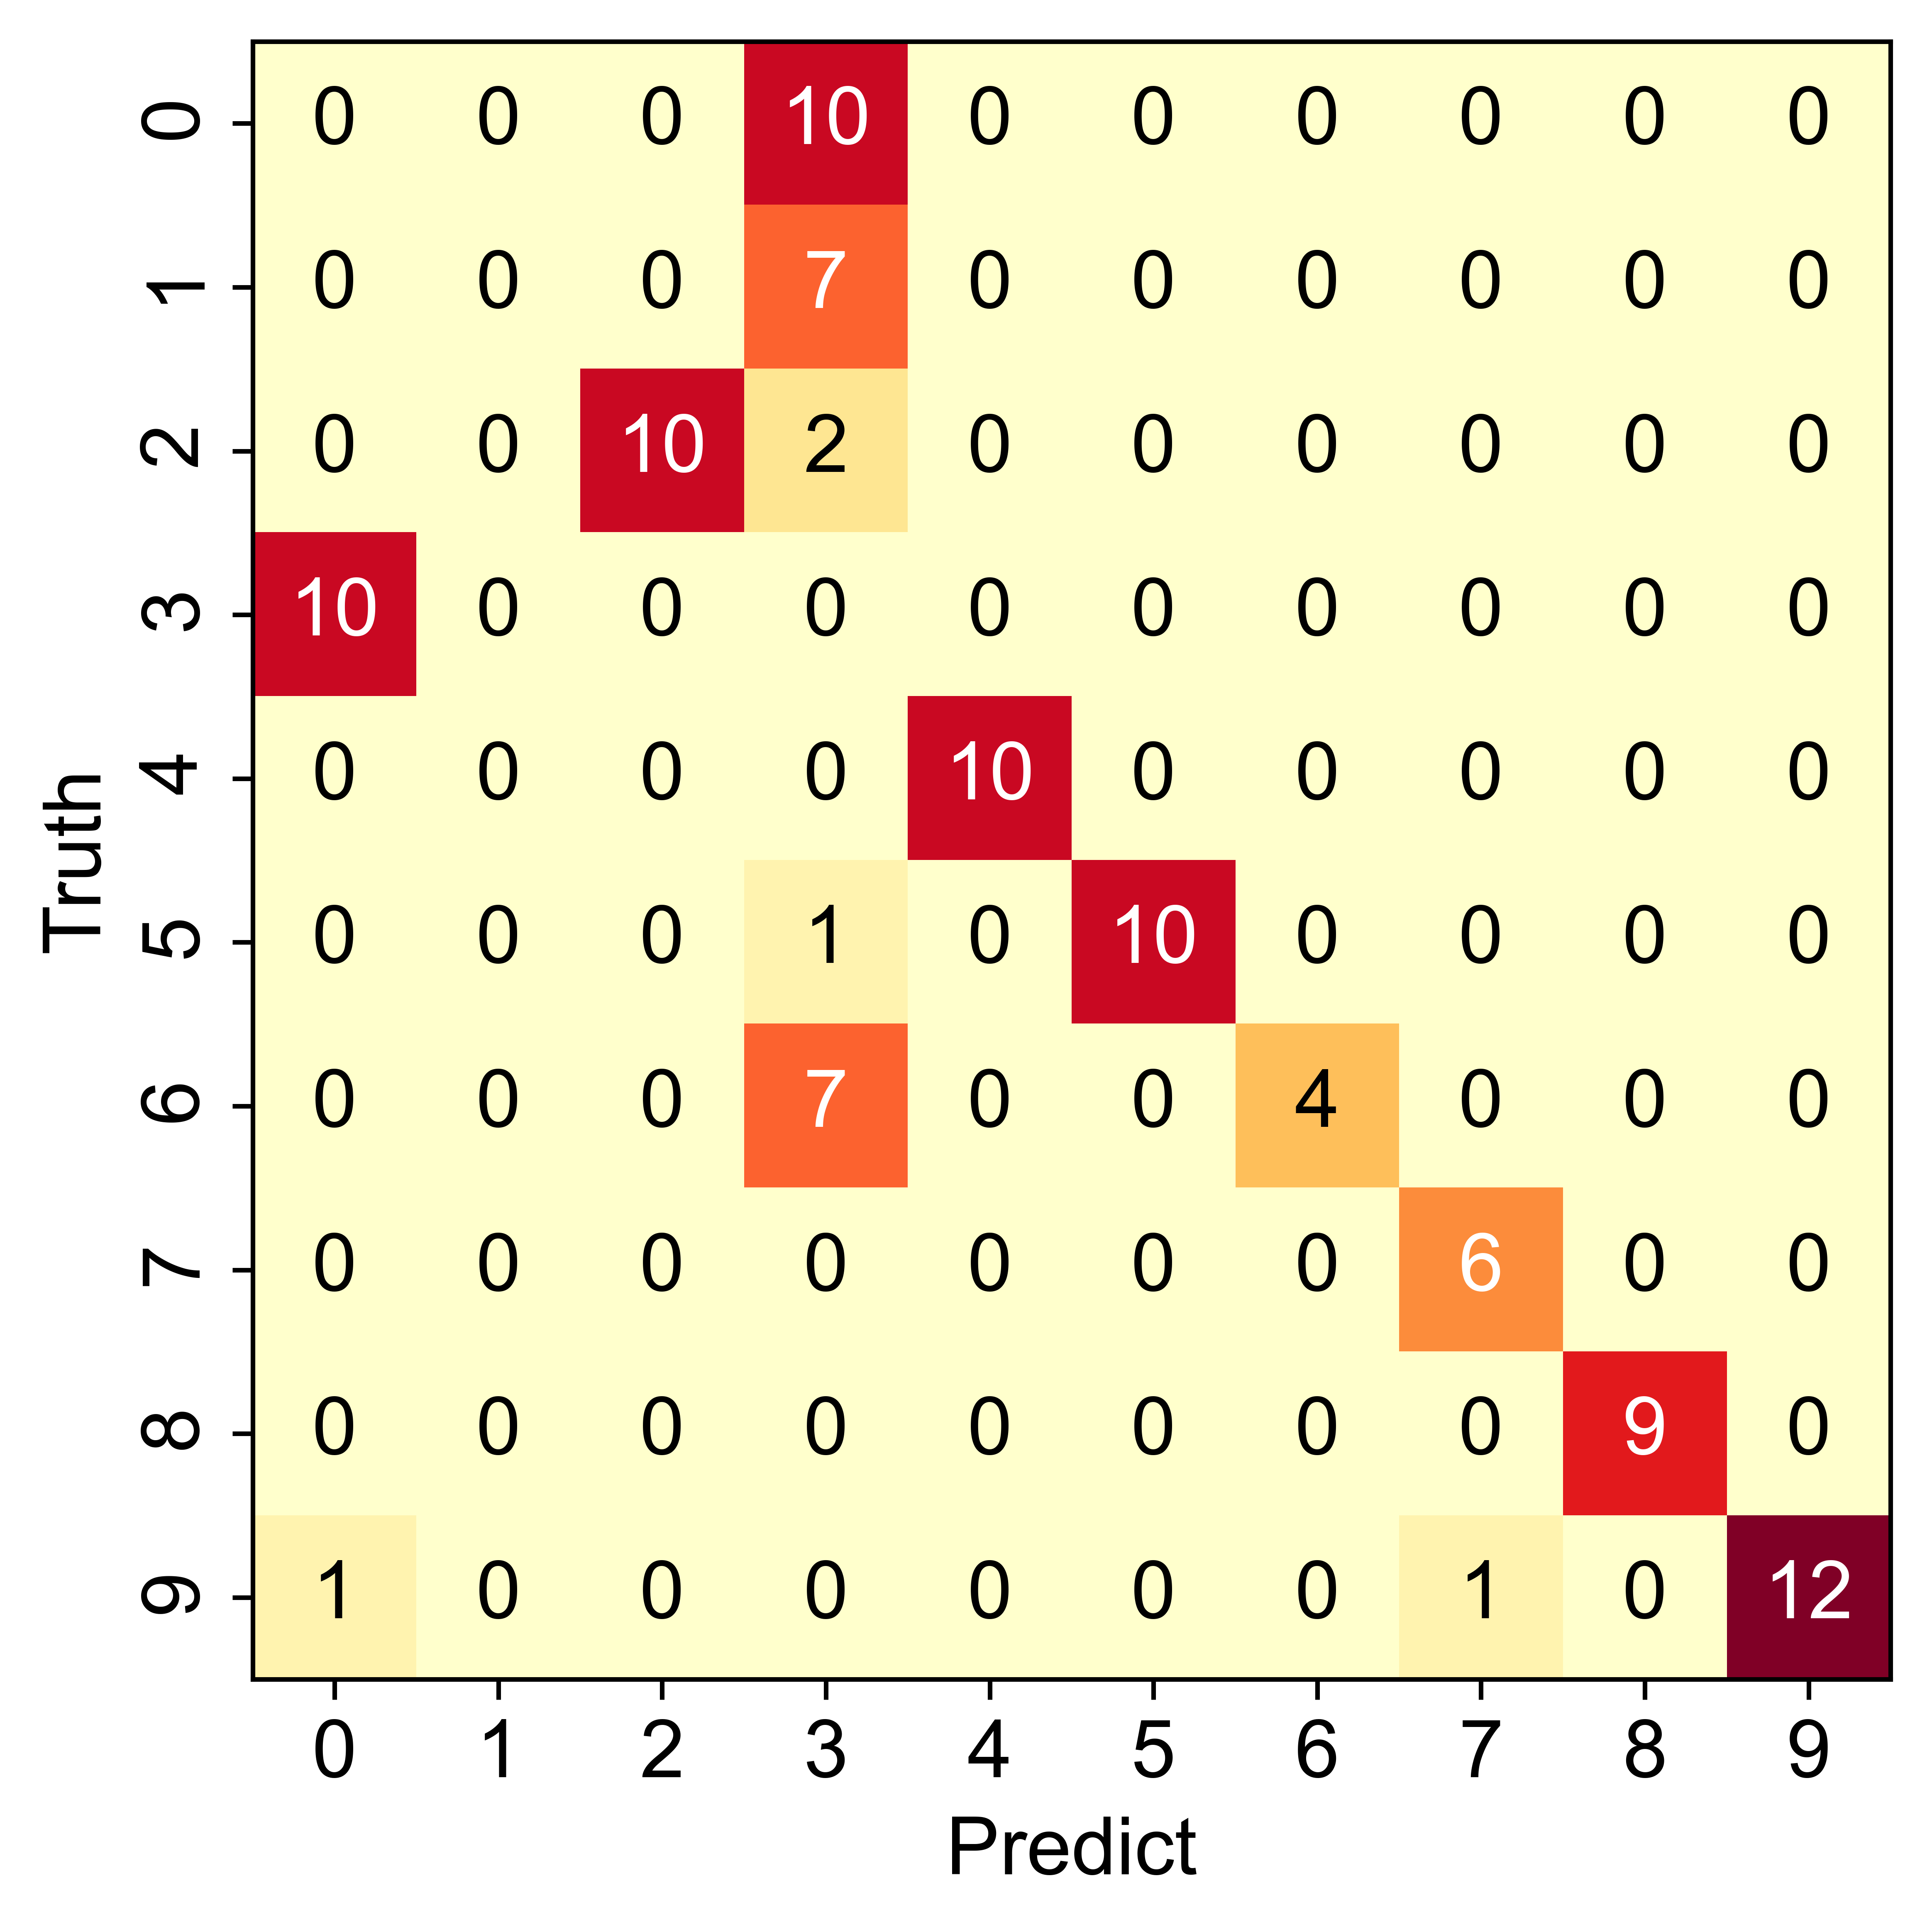

In [21]:
import matplotlib.pylab as plt
import numpy as np
plt.rcParams.update(plt.rcParamsDefault)
fontparams = {'font.size': 14,'font.family':'Arial'}
plt.rcParams.update(fontparams)
labelparams = {'size': 14,'family':'Arial'}
titleparams = {'size': 14,'family':'Arial'}

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

cf_matrix = confusion_matrix(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy())
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cm = confusion_matrix(y_true=labels.cpu().detach().numpy(), y_pred=predicted.cpu().detach().numpy(), normalize=None)
fig, ax = plt.subplots(1,1,figsize=(6.5,6.5*0.75),dpi=1000)
# plt.imshow(cm, cmap='viridis',vmin=0,vmax=1)
plt.imshow(cm, cmap='YlOrRd')
# plt.colorbar()

# plt.title(title)
plt.xlabel("Predict")
plt.ylabel("Truth")
plt.yticks(range(class_names.__len__()), class_names, rotation=90)
plt.xticks(range(class_names.__len__()), class_names, rotation=0)

plt.tight_layout()

# plt.colorbar() 

for i in range(class_names.__len__()):
    for j in range(class_names.__len__()):
        if j == np.argmax(cm[i,:]):
            color = (1, 1, 1)
        else:
            color = (0, 0, 0)
        value = cm[i, j]
        plt.text(j, i, value, verticalalignment='center', horizontalalignment='center', color=color)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.show()